## 航空宇宙情報システム学第二

<h1><center> 第7回 線形判別 〜ロジスティック回帰による分類〜 </center> </h1>

<center>

2023年5月23日

担当教員: 矢入健久

e-mail: yairi@g.ecc.u-tokyo.ac.jp
</center>

# はじめに

前回、前々回は、曲線当てはめ(curve fitting)または回帰(regression)と呼ばれる問題を扱いました。簡単に言えば、関数
$$
y = f_\boldsymbol{\alpha}(\boldsymbol{x})
$$
が与えられたデータ ${\cal D}=\{ (\boldsymbol{x}_0,y_0),(\boldsymbol{x}_1,y_1),\ldots, (\boldsymbol{x}_{N-1},y_{N-1}) \}$によく当てはまるように、関数のパラメータ$\boldsymbol{\alpha}$を求める問題でした。<font color="blue">回帰問題では、関数の出力である$y$は目標変数と呼ばれ、一般に**連続値(実数値)**を取ります。</font>

それに対して、<font color="red">**分類**(classification)と呼ばれる問題では、$y$の取りうる値が整数値、特に**二値分類**では、0か1かのどちらか</font>に限定されます。
今日は、分類（判別、識別とも呼ばれる）手法の代表のひとつである**ロジスティック回帰(logistic regression)** を紹介します。<font color="red">手法名に「回帰」という言葉が入っていますが、実際には回帰ではなく分類を目的としている</font>ところが紛らわしいのですが、どうしてそういう名前になっているかは、追々分かってきます。

## (二値)線形分類問題

人工的な例題ですが、次のようなデータがあるとします。$x_1$と$x_2$は2つの説明変数、$y$は0か1の値を取る説明変数で「ラベル」と呼ぶこともあります。

|$x_1$|$x_2$|$y$|
|-|-|-|
| 3.01 | 5.03|1|
|-2.81 | 0.74|0|
| 0.25 | 1.52|1|
|-2.59 | -2.01|0|
| 2.31 | 2.84|1|
| 1.68 | 3.31|1|
|-1.16 | 4.1 |0|
|-2.26 |-1.08|0|
| 4.33 | 0.63|1|
|-0.3  |-3.61|0|

Pandas のデータフレームオブジェクトは次のような感じで作ることができます。

In [ ]:
import pandas as pd
# 説明変数データ
Xlst = [[ 3.01,  5.03],
 [-2.81,  0.74],
 [ 0.25,  1.52],
 [-2.59, -2.01],
 [ 2.31,  2.84],
 [ 1.68,  3.31],
 [-1.16,  4.1 ],
 [-2.26, -1.08],
 [ 4.33,  0.63],
 [-0.3,  -3.61]]
 # ターゲット変数データ
ylst = [1, 0, 1, 0, 1, 1, 0, 0, 1, 0]

# データフレーム
df0 = pd.DataFrame(Xlst,columns=["x1","x2"])
df0["y"] = ylst
df0


,x1,x2,y
0,3.01,5.03,1
1,-2.81,0.74,0
2,0.25,1.52,1
3,-2.59,-2.01,0
4,2.31,2.84,1
5,1.68,3.31,1
6,-1.16,4.10,0
7,-2.26,-1.08,0
8,4.33,0.63,1
9,-0.30,-3.61,0


2つの説明変数をそれぞれ横軸、縦軸に取り、目標変数の値が0のサンプルを青いマーカー、1のサンプルをオレンジのマーカーでプロットすると、次のような散布図が得られます。

(-4.0, 6.0)

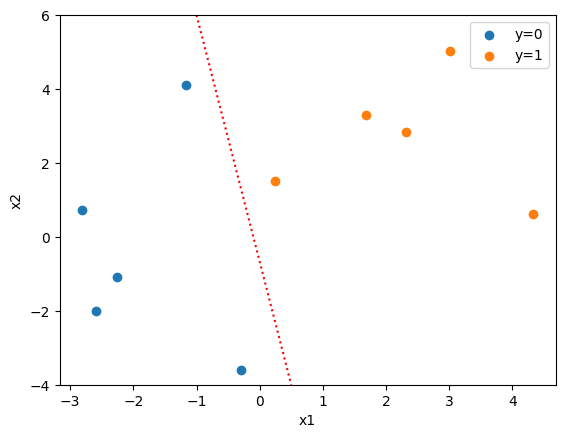

In [ ]:
import matplotlib.pyplot as plt

# y=0のサンプルをプロット
ix0 = (df0.y==0)
plt.scatter(df0.loc[ix0,"x1"],df0.loc[ix0,"x2"],label="y=0")
# y=1のサンプルをプロット
ix1 = (df0.y==1)
plt.scatter(df0.loc[ix1,"x1"],df0.loc[ix1,"x2"],label="y=1")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
# 識別境界線
plt.plot([-1,0.5],[6,-4],"r:")
plt.ylim([-4,6])

二値の線形分類とは、2つのクラス($y=0$と$y=1$)のサンプルをできるだけきれいに分割するような直線（一般には超平面）
$$
b_0 + b_1 x_1 + b_2 x_2 = 0
$$
を求めることになります。これを識別境界線（一般には識別境界面）と呼びます。例えば、この例題では赤い点線が識別境界線です。

与えられたデータからそのような線形識別面を求める方法・アルゴリズムには様々なものが存在します。代表的なのが、
* フィッシャー判別分析
* サポートベクトルマシン(最大マージン分類器)
* ロジスティック回帰

などですが、今回はその中の**ロジスティック回帰**を取り上げたいと思います。

# ベルヌーイ分布モデルの最大尤度推定

分類問題から少し離れるのですが、ロジスティック回帰モデルを理解する上で、ベルヌーイ分布と最尤法が前提となるので、その話を手短(?)にしておきたいと思います。

次のような例題を考えます。


## **[例題]** くじの当選確率の推定
---
当選確率を$q$ ($0\leq q \leq 1$)とするくじがあるとします。このくじを$N$回引いた結果、
$$
y_0, y_1, \ldots, y_{N-1}
$$
という結果が得られました。ただし、各$y_i$ ($i=0,1,\ldots,N-1$)は、$0$または$1$の値を取り、$0$はハズレ、$1$は当たり、を表すとします。このとき、このくじの当選確率$q$を推定してください。

---

この問題、あまり深く考えなくても、直感的に、「当たった回数を、くじを引いた回数で割れば良いんじゃない？」と思いますよね。この考えに従えば、$q$の値は、

$$
\hat{q} = \frac{\sum_{i=1}^N y_i}{N}
$$
となるはずです。これが正しいかどうか、最尤法に従って考えてみます。

## 尤度と対数尤度

尤度(likelihood)は、パラメータ(例題の場合は$q$)の値を仮定したときに、観測結果(例題の場合は、$Y = \{y_0, y_1, \ldots, y_{N-1} \}$)が生じる確率によって定義されます。従って、例題の場合、尤度を$L(q\vert Y)$と書くとすると、通常、各回のくじの当たりハズレは独立しているので、
$$
L(q\vert Y) = p(y_0 \vert q)\cdot p(y_1 \vert q)\cdot \cdots p(y_{N-1} \vert q) = \prod_{i=0}^{N-1} p(y_i \vert q)
$$
となります。ここで、<font color="red">$p(y_i \vert q)$は、$i$番目のくじの結果が$y_i$となる確率</font>を表します。$y_i$は$0$か$1$なので、場合分けを使えば、
$$
p(y_i \vert q) =
\left\{
\begin{array}{ll}
1-q & \mbox{if $y_i=0$} \\
q & \mbox{if $y_i=1$}
\end{array}
\right.
$$
と書けますが、次のように無理やり1行で書くこともできます。
$$
p(y_i \vert q) = (1-q)^{1-y_i} \cdot q^{y_i}
$$
こちらの書き方を採用すれば、先程の尤度は、
$$
L(q\vert Y) =\prod_{i=0}^{N-1} (1-q)^{1-y_i} \cdot q^{y_i}
$$
となります。

対数尤度(関数)は、その名の通り、尤度の対数を取ったもので、$l(q\vert Y)$と書くとすると、
$$
\begin{align}
l(q\vert Y) &= \log L(q\vert Y) = \log \prod_{i=0}^{N-1} (1-q)^{1-y_i} \cdot q^{y_i} = \sum_{i=0}^{N-1} \log \{ (1-q)^{1-y_i} \cdot q^{y_i} \} \\
&= \sum_{i=0}^{N-1} \{ (1-y_i) \log (1-q)  + y_i \log q\}
\end{align}
$$


## 最大尤度推定法(最尤法)によるパラメータ推定

最尤法はその名の通り、尤度関数または対数尤度関数を最大化するようなパラメータの値を求める考え方です。上述のくじ引きの例題で、$N=10$で、結果$Y$が、

|$y_0$|$y_1$|$y_2$|$y_3$|$y_4$|$y_5$|$y_6$|$y_7$|$y_8$|$y_9$|
|-|-|-|-|-|-|-|-|-|-|
|0|0|1|0|1|0|0|0|1|0|

だったとしたとき、$0\leq q \leq 1$ に対して対数尤度関数$l(q\vert Y)$の値をプロットしてみると、

<ipython-input-5-a5201c2956ad>:7: RuntimeWarning: divide by zero encountered in log
  ll = (N-sum(Y))*np.log(1-q)+sum(Y)*np.log(q)


Text(0, 0.5, 'log likelihood')

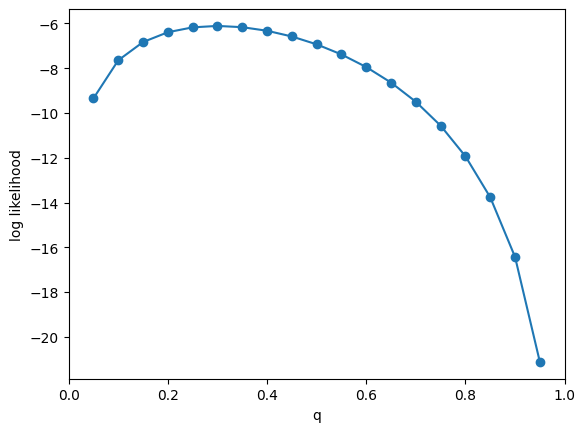

In [ ]:
import numpy as np
# くじびきの結果
Y = [0,0,1,0,1,0,0,0,1,0]
# パラメータq (0<q<1)に対して対数尤度を計算
def llkhd_ber(q):
  N = len(Y)
  ll = (N-sum(Y))*np.log(1-q)+sum(Y)*np.log(q)
  return ll
qlst = np.linspace(0.0,1.0,21)
plt.plot(qlst,llkhd_ber(qlst),"o-")
plt.xlim([0,1])
plt.xlabel("q")
plt.ylabel("log likelihood")

のようになり、確かに、$q=0.3$ あたりで極大(=最大)を取っていることが分かります。実際に、対数尤度関数$l(q\vert Y)$を$q$について微分し、傾きが$0$になる条件を考えると、

$$
\frac{d l(q\vert Y)}{d q}= - \left(N-\sum_{i=0}^{N-1} y_i \right) \frac{1}{1-q} + \left(\sum_{i=0}^{N-1} y_i \right) \frac{1}{q} = 0
$$

$$
\therefore \hat{q} = \frac{\sum_{i=0}^{N-1} y_i}{N}
$$
となり、予想通りの結果になりました。

複雑な問題になると、（対数）尤度関数の極値が必ずしも最大値にならず、極大値が複数存在するような場合もありますが、「尤度が最大になるようなパラメータの値を求める」という最尤法の考え方自体は変わりません。



# ロジスティック関数

また話は変わりますが、次の式で表される関数を（標準）ロジスティック関数、またはシグモイド関数と呼びます。

$$
f(z) = \frac{1}{1+e^{-z}}
$$

(注) 本来は、$x$を独立変数として$f(x)$として表すのが自然ですが、後で$\boldsymbol{x}$を説明変数ベクトルとして使うので、混乱が生じないようにここでは変数$z$を使っています。$z$は実数とします($z \in R$)。

Matplotlibでグラフを書く前に$f(z)$の概形を想像してみましょう。まず、$-\infty < z < \infty$に対して、$\infty > e^{-z} > 0$ なので、$f(z)$の値域は、$0 < f(z) < 1$です。また、
$$
\begin{align}
\lim_{z\rightarrow -\infty} f(z) &= 0 \\
f(0) &= \frac{1}{2} \\
\lim_{z\rightarrow \infty} f(z) &= 1
\end{align}
$$
なので、$z$を$-\infty$から$\infty$ に動かしたとき、 $f(z)$は$-1$から$1$まで動くことが分かります。また、
$$
f(-z) = \frac{1}{1+e^z} = \frac{e^{-z}}{1+e^{-z}} = 1 - \frac{1}{1+e^{-z}} = 1 - f(z)
$$
なので、$(0,\frac{1}{2})$に関して点対称の形になっていることが分かります。

さらに、導関数については、
$$
\begin{align}
\frac{d f(z)}{d z} &= f^\prime (z) = \frac{e^{-z}}{(1+e^{-z})^2} = f(z) \left(1 - f(z) \right) \\
&> 0
\end{align}
$$
となるので、<font color="red">$f(z)$は狭義に単調増加である</font>ことも分かります。

それでは、グラフを描いてみます。

Text(0, 0.5, 'f(z)')

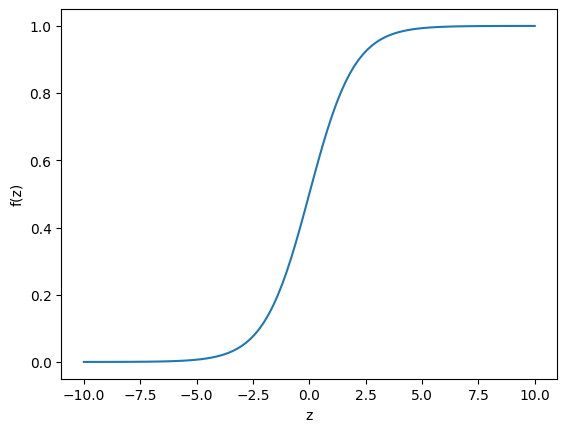

In [ ]:
zlst = np.linspace(-10,10,101)
flst = 1/(1+np.exp(-zlst))
plt.plot(zlst,flst)
plt.xlabel("z")
plt.ylabel("f(z)")

このように、（標準）ロジスティック関数は、単調増加ですが$z=0$付近で急激に増加し、それ以外の領域では非常になだらかになっています。そのため、(単位)ステップ関数
$$
H(z) =
\left\{
\begin{array}{ll}
1 & \mbox{if $z > 0$} \\
0 & \mbox{if $z \leq 0$}
\end{array}
\right.
$$
の近似・代替として使われることがあります。ステップ関数は$z=0$において不連続かつ微分不可なのに対して、ロジスティック関数は連続かつ微分可能であるため、理論的にも実用的にも色々と嬉しいことがあります。シグモイド関数の名前でニューラルネットワークの活性化関数として昔から使われてきたのもそのためです。

そして、標準ロジスティック関数の値域が$(0,1)$であること（と単調増加であること）を利用して、<font color="red">$-\infty$ から $\infty$ までの実数値を、$0$から$1$までの確率値に変換する</font>目的でもよく使われます。

## **[例題]**くじの当選確率をロジスティック関数で当てはめる

先ほどのくじ引きの例題では、個々のくじの当選確率は等しく$q$であるという前提でした。ここで実は、<font color="red">各くじには重さにばらつきがあり、重いくじほど当たる確率が高そう</font>ということが分かったらどうでしょうか？
具体的には、各くじの当落$y_i$に加えて、各くじの重さ$x_i$(g)が次のように与えらえたとします。

|$i$|$0$|$1$|$2$|$3$|$4$|$5$|$6$|$7$|$8$|$9$|
|-|-|-|-|-|-|-|-|-|-|-|
|$y_i$|0|0|1|0|1|0|0|0|1|0|
|$x_i$|2.0|1.9|2.3|2.1|2.4|2.2|2.1|2.3|2.2|1.8|

各くじの重さ $x_i$ を横軸、当落$y_i$を縦軸にしてプロットすると、

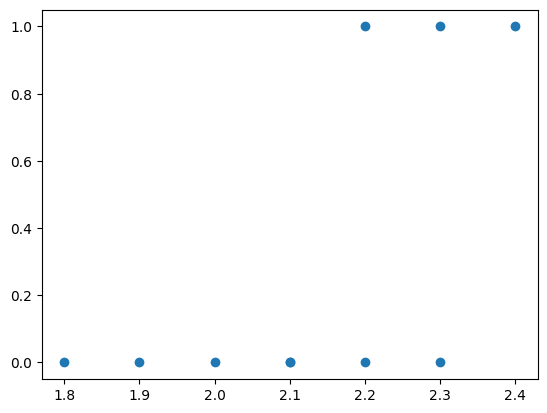

In [ ]:
# くじの重さのリスト
X = [2.0,1.9,2.3,2.1,2.4,2.2,2.1,2.3,2.2,1.8]
plt.scatter(X,Y)

これを見ると、$x=2.2$ から $x=2.3$ のあたりに閾値がありそうです。
そこで、各くじの当選確率$q_i$を、ロジスティック関数
$$
q_i = f(b_0+b_1\cdot x_i) = \frac{1}{1+e^{-(b_0+b_1 x_i)}}
$$
で予測するモデルを考えます。<font color="red">このモデルのパラメータは、$b_0$と$b_1$</font>です。合わせて、$\boldsymbol{\beta}=[b_0,b_1]^\top$と書くことにします。

ここで再び尤度関数を考えます。この場合の<font color="blue">尤度は、「パラメータ$\boldsymbol{\beta}$の値と$\{x_0,x_1,\cdots,x_9\}$が与えられたときに、くじの結果$\{y_0,y_1,\cdots,y_9\}$が得られる確率」</font>になります。
すなわち、
$$
L(\boldsymbol{\beta}\vert X,Y) =\prod_{i=0}^{N-1} (1-q_i)^{1-y_i} \cdot q_i^{y_i} = \prod_{i=0}^{N-1} (1-f(b_0+b_1\cdot x_i))^{1-y_i} \cdot f(b_0+b_1\cdot x_i)^{y_i}
$$
であり、対数尤度関数は、
$$
l(\boldsymbol{\beta}\vert X,Y) = \log L(\boldsymbol{\beta}\vert X,Y)
= \sum_{i=0}^{N-1} \left\{ (1-y_i) \cdot \log (1-f(b_0+b_1\cdot x_i))
+ y_i \cdot \log f(b_0+b_1\cdot x_i) \right\}
$$
となります。ここで、線形回帰のときのように、$\boldsymbol{x}_i=[1,x_i]^\top$ のように説明変数ベクトルを定義し、$z_i = \boldsymbol{\beta}\cdot \boldsymbol{x}_i$とすれば、
$$
l(\boldsymbol{\beta}\vert X,Y) = \sum_{i=0}^{N-1} \left\{ (1-y_i) \cdot \log (1-f(\boldsymbol{\beta}\cdot \boldsymbol{x}_i))
+ y_i \cdot \log f(\boldsymbol{\beta}\cdot \boldsymbol{x}_i) \right\}
$$
のように少しだけ簡素に書くことができます。

しかし、残念ながら、線形回帰の場合とは違って、極値条件
$$
\frac{\partial l(\boldsymbol{\beta}\vert X,Y)}{\partial \boldsymbol{\beta}} = \boldsymbol{0}
$$
は<font color="red">容易に解くことができないので、数値的な解法を用いざるを得ません。</font>
その方法については後述しますが、とりあえず、対数尤度の最大値（極大値）が存在しそうなことだけ確認しておきます。

くじ引きの例題で、
1. $b_1=16.5$に固定して、$b_0$を$-50.0$から$-25.0$まで動かしたとき。
1. $b_0=-37.0$に固定して、$b_1$を$10.0$から$20.0$まで動かしたとき。

それぞれの対数尤度をプロットしたのが次のコードです。

Text(0, 0.5, 'log likelihood')

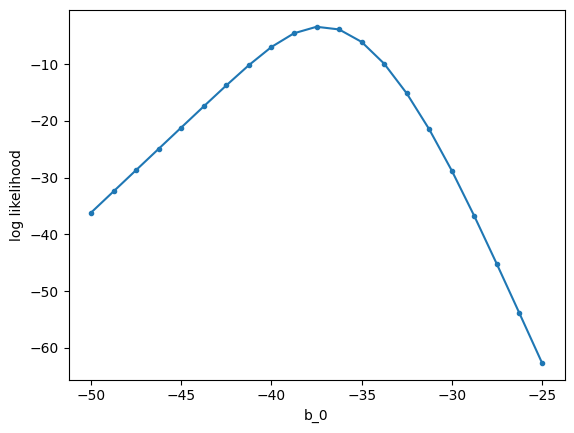

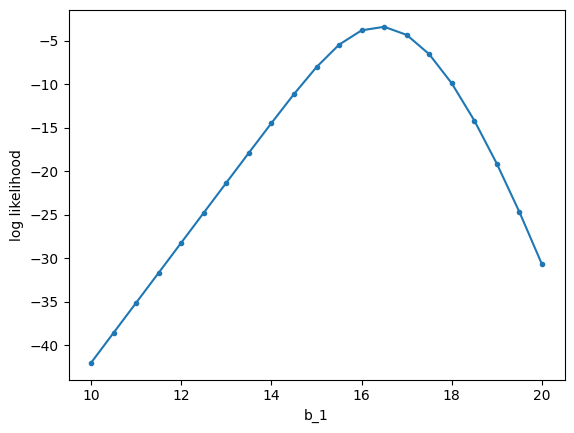

In [ ]:
# Numpyのarray型に変換
Ylot = np.array(Y)
# 常に1の列を説明変数の列の左に加える
Xlot = np.array([[1]*len(X),X]).T

# ロジスティック関数
def logifun(z):
  return 1/(1+np.exp(-z))

# パラメータbeta に対して対数尤度を計算
def llkhd_lot(beta):
  ll = np.sum((1-Ylot)*np.log(1-logifun(np.dot(Xlot,beta)))) + np.sum(Ylot*np.log(logifun(np.dot(Xlot,beta))))
  return ll

#
b0lst = np.linspace(-50.0,-25.0,21)
llkhd_b0 = []
for b0 in b0lst:
  beta = np.array([b0,16.5])
  llkhd_b0.append(llkhd_lot(beta))
plt.plot(b0lst,llkhd_b0,'.-')
plt.xlabel("b_0")
plt.ylabel("log likelihood")

b1lst = np.linspace(10.0,20.0,21)
llkhd_b1 = []
for b1 in b1lst:
  beta = np.array([-37.0,b1])
  llkhd_b1.append(llkhd_lot(beta))
plt.figure()
plt.plot(b1lst,llkhd_b1,'.-')
plt.xlabel("b_1")
plt.ylabel("log likelihood")


これら２つのグラフから、大体、$b_0=-37$, $b_1=16$付近で対数尤度が最大になりそうなこと、また、<font color="blue">最大値（極大値）付近では、対数尤度関数の形が上に凸な二次関数（放物線）に似ている</font>こと、が分かります。


# ロジスティック回帰

## ロジスティック回帰モデルの学習

あらためて、二値分類問題を定式化しておくと、データの各サンプルは、$m$個の説明変数$x_j$  ($j=1,2,\ldots,m$)と、目標変数$y$ から構成されている点は、（重）回帰と同じです。回帰と異なる点は、<font color="red">目標変数$y$が取りうる値が連続値(実数値)ではなくて、$0$か$1$の二値に限定されるという点</font>です。

（訓練）データを回帰のときと同様に、次のように行列とベクトルで表現しておきます。

$$
\boldsymbol{X} =
\left[\begin{matrix}
\boldsymbol{x}_0 \\
\boldsymbol{x}_1 \\
\vdots \\
\boldsymbol{x}_{n-1}
\end{matrix}\right]
=
\left[\begin{matrix}
1 & x_{0,1} & \cdots & x_{0,m}\\
1 & x_{1,1} & \cdots & x_{1,m}\\
\vdots \\
1 & x_{n-1,1} & \cdots & x_{n-1,m}\\
\end{matrix}\right]
$$
$$
\boldsymbol{y} =
\left[\begin{matrix}
y_0 \\
y_1 \\
\vdots \\
y_{n-1}
\end{matrix}\right] \in {\cal B}^n
$$

この時、<font color="blue">ロジスティック回帰モデルは、説明変数ベクトル$\boldsymbol{x}_i$が与えられたときに、その目標変数の値(ラベル)が1である条件付き確率</font>を、ロジスティック関数を使って、
$$
p(y_i = 1 \vert \boldsymbol{x}_i ; \boldsymbol{\beta}) = \frac{1}{1+e^{-\boldsymbol{\beta}\cdot\boldsymbol{x}_i}}=f(\boldsymbol{\beta}\cdot\boldsymbol{x}_i)
$$
によって表すモデルです。

そして、データが与えられたときのこのモデルの対数尤度関数は、先ほどの例題で計算したように、

$$
l(\boldsymbol{\beta}\vert X,Y) = \sum_{i=0}^{N-1} \left\{ (1-y_i) \cdot \log (1-f(\boldsymbol{\beta}\cdot \boldsymbol{x}_i))
+ y_i \cdot \log f(\boldsymbol{\beta}\cdot \boldsymbol{x}_i) \right\}
$$

となります。この後、対数尤度関数を簡略化して、単に$l(\boldsymbol{\beta})$と書くことにします。<font color="blue">この対数尤度をマイナスしたもの（符号を反転させたもの）が、回帰における残差二乗和に相当</font>します。
しかし、前述のように、線形最小二乗法とは異なり、<font color="red">ロジスティック回帰モデルの対数尤度を最大化するパラメータ$\hat{\boldsymbol{\beta}}$を解析的に求めることはできないので、反復計算によって求める</font>ことになります。

## ニュートン法による対数尤度の最大化

上で求めたロジスティック回帰モデルの対数尤度関数$l(\boldsymbol{\beta})$をパラメータ$\boldsymbol{\beta}$について最大化するというのは、
数値最適化の話になるので、詳しくはこの授業の終盤で取り上げるつもりですが、基本的な考え方だけ説明しておきます。

今、最大化したい関数$l(\boldsymbol{\beta})$を、$\boldsymbol{\beta}=\boldsymbol{\beta}^{(0)}$ の周りで2次のテイラー近似を行います。$\boldsymbol{\beta}$はベクトル(多変量)なので、単変量の場合と比べて煩雑になりますが、
$$
\begin{align}
l(\boldsymbol{\beta}) &\approx l(\boldsymbol{\beta}^{(0)}) + (\boldsymbol{\beta}-\boldsymbol{\beta}^{(0)})^\top \nabla l(\boldsymbol{\beta}^{(0)})
+ \frac{1}{2} (\boldsymbol{\beta}-\boldsymbol{\beta}^{(0)})^\top
\nabla^2 l(\boldsymbol{\beta}^{(0)}) (\boldsymbol{\beta}-\boldsymbol{\beta}^{(0)}) \\
&\approx l(\boldsymbol{\beta}^{(0)}) + (\boldsymbol{\beta}-\boldsymbol{\beta}^{(0)})^\top \boldsymbol{g}^{(0)}
+ \frac{1}{2} (\boldsymbol{\beta}-\boldsymbol{\beta}^{(0)})^\top
\boldsymbol{H}^{(0)} (\boldsymbol{\beta}-\boldsymbol{\beta}^{(0)})
\end{align}
$$

となります。<font color="blue">ここで、
$$
\boldsymbol{g} = \nabla l(\boldsymbol{\beta})=
\left[
  \begin{matrix}
  \frac{\partial l(\boldsymbol{\beta})}{\partial b_0} \\
  \frac{\partial l(\boldsymbol{\beta})}{\partial b_1}
  \end{matrix}
\right]
$$
は、対数尤度関数の勾配ベクトルであり、
$$
\boldsymbol{H} = \nabla^2 l(\boldsymbol{\beta})=
\left[
\begin{matrix}
\frac{\partial^2 l(\boldsymbol{\beta})}{\partial b_0^2} & \frac{\partial^2 l(\boldsymbol{\beta})}{\partial b_0 \partial b_1} \\
\frac{\partial^2 l(\boldsymbol{\beta})}{\partial b_1 \partial b_0} & \frac{\partial^2 l(\boldsymbol{\beta})}{\partial b_1^2}
\end{matrix}
\right]
$$
は、ヘッセ行列(Hessian)</font>と呼ばれるものです。

もし、ヘッセ行列$\boldsymbol{H}$が負定値(negative definite)であれば、上の対数尤度関数の2次近似（右辺）は、
$$
\boldsymbol{\beta} = \boldsymbol{\beta}^{(0)} - {\boldsymbol{H}^{(0)}}^{-1} \boldsymbol{g}^{(0)}
$$
で最大になります。そこで、$k=0,1,2\ldots,$に対して、
$$
\boldsymbol{\beta}^{(k+1)} = \boldsymbol{\beta}^{(k)} - {\boldsymbol{H}^{(k)}}^{-1} \boldsymbol{g}^{(k)}
$$
のように反復的にパラメータベクトル$\boldsymbol{\beta}$の推定値を更新していけば、対数尤度関数を最大化する値に近づいていくはず、というのがニュートン法の考え方です。

**(注意)** ニュートン法は、初期推定解$\boldsymbol{\beta}^{(0)}$が十分に最適解に近く、かつ、ヘッセ行列$\boldsymbol{H}^{(k)}$が常に負定値である場合（最小化の場合は常に正定値）は非常に効率的なアルゴリズムですが、そうでない場合は計算が発散したり不安定になったりするので、工夫が必要です。

さて、問題は、対数尤度関数の勾配ベクトル$\boldsymbol{g}$とヘッセ行列$\boldsymbol{H}$を具体的に求めるか、ということですが、前述のロジスティック関数の性質、
$$
\frac{d f(z)}{d z} = f^\prime (z) = \frac{e^{-z}}{(1+e^{-z})^2} = f(z) \left(1 - f(z)\right)
$$
などを使うと、
$$
\boldsymbol{g}^{(k)} = \boldsymbol{X}^\top (\boldsymbol{y} - \boldsymbol{p}^{(k)})
$$
$$
\boldsymbol{H}^{(k)} = - \boldsymbol{X}^\top \boldsymbol{W}^{(k)} \boldsymbol{X}
$$
という結果になります。ここで、$\boldsymbol{p}^{(k)}$は、
$$
\boldsymbol{p}^{(k)} = \left[
  \begin{matrix}
  f(\boldsymbol{\beta}^{(k)}\cdot \boldsymbol{x}_0)\\
  f(\boldsymbol{\beta}^{(k)}\cdot \boldsymbol{x}_1)\\
  \vdots \\
  f(\boldsymbol{\beta}^{(k)}\cdot \boldsymbol{x}_{N-1})
  \end{matrix}
  \right]
$$
であり、$\boldsymbol{W}^{(k)}$は、対角成分$w_{i,i}$が、
$$
  w_{i,i} = w_{i} =
  f(\boldsymbol{\beta}^{(k)}\cdot \boldsymbol{x}_i) \cdot
  (1-f(\boldsymbol{\beta}^{(k)}\cdot \boldsymbol{x}_i))
$$
であるような対角行列です。

まとめると、ロジスティック回帰モデルのパラメータの更新則は、
$$
\boldsymbol{\beta}^{(k+1)} = \boldsymbol{\beta}^{(k)} + (\boldsymbol{X}^\top \boldsymbol{W}^{(k)} \boldsymbol{X})^{-1} \boldsymbol{X}^\top (\boldsymbol{y} - \boldsymbol{p}^{(k)})
$$
となります。これは、IRLS(iteratively re-weighted least squares)アルゴリズムと呼ばれています。


**(注意)** 対角行列$\boldsymbol{W}^{(k)}$はサイズが$N\times N$で、非対角成分は全て0なので、データ数($N$)が大きい場合に愚直に$\boldsymbol{X}^\top \boldsymbol{W}^{(k)} \boldsymbol{X}$を計算するのは無駄が大きいです。実は、
$$
\boldsymbol{W} \boldsymbol{X} = \left[
  \begin{matrix}
  w_{0} \cdot \boldsymbol{x}_0^\top \\
  w_{1} \cdot \boldsymbol{x}_1^\top \\
  \vdots \\
  w_{N-1} \cdot \boldsymbol{x}_{N-1}^\top
  \end{matrix}
  \right]
$$
であることに気が付けば、実装上の無駄を無くすことができます。




In [ ]:
import numpy.linalg as la
# パラメータの初期値
#beta = np.array([-3.0,1.0])
beta = np.array([0.0,0.0])

print("k={}: beta={}, l={}".format(0,beta,llkhd_lot(beta)))
# とりあえず、10回繰り返してみる
for k in range(10):
  # ベクトル p
  p = logifun(np.dot(Xlot,beta))
  # 行列Wの対角成分を集めたベクトル
  w = p*(1-p)
  # 勾配ベクトル
  g = np.dot(Xlot.T,Ylot-p)
  # ヘッセ行列
  H = - np.dot(Xlot.T,w.reshape((-1,1))*Xlot)
  # H^{-1} g
  dlt = la.solve(H,g)
  # パラメータ更新
  beta -= dlt
  # 表示
  print("k={}: beta={}, l={}".format(k+1,beta,llkhd_lot(beta)))

k=0: beta=[0. 0.], l=-6.931471805599452
k=1: beta=[-14.3364486    6.35514019], l=-4.124059016372293
k=2: beta=[-24.6221626   10.92528971], l=-3.5354329299474623
k=3: beta=[-33.00171552  14.63751664], l=-3.377683189661029
k=4: beta=[-36.7032048   16.27388553], l=-3.3616569919978168
k=5: beta=[-37.1956542   16.49131006], l=-3.3614410922511473
k=6: beta=[-37.20296281  16.49453437], l=-3.361441046038941
k=7: beta=[-37.20296439  16.49453507], l=-3.3614410460389412
k=8: beta=[-37.20296439  16.49453507], l=-3.361441046038942
k=9: beta=[-37.20296439  16.49453507], l=-3.361441046038939
k=10: beta=[-37.20296439  16.49453507], l=-3.3614410460389395


7ステップ目くらいで、$b_0=-37.20296439$, $b_1=16.49453507$という値に収束しています。

確認のため、<font color="blue">Scikit-learn で提供されているロジスティック回帰のサブモジュール LogisticRegression </font>で検算してみます。

ただし、<font color="red">デフォルトでは、前回お話した$L_2$正則化が有効になっているので、
`penalty=None` というオプションで無効化</font>します。

In [ ]:
from sklearn.linear_model import LogisticRegression
#Training
mdl_lot = LogisticRegression(penalty=None,fit_intercept=False)
mdl_lot.fit(Xlot,Ylot)
print(mdl_lot.coef_)

[[-37.20317118  16.49462249]]


小数第3位以下が微妙に違いますが、、ほぼ同じ解が得られました。

別の確認方法としては、推定されたパラメータ値$\hat{\beta}_0$, $\hat{\beta}_1$ を使って、
$$
z_i = \hat{\beta}_0 + \hat{\beta}_1 \cdot x_i
$$
を計算し、$(z_i, y_i)$  ($i=0,1,\ldots,N-1$) と、標準ロジスティック関数 $y=\frac{1}{1+e^{-z}}$ との当てはまり具合を見てみるというのもあります。

Text(0, 0.5, '$y_i$ / $f(z_i)$')

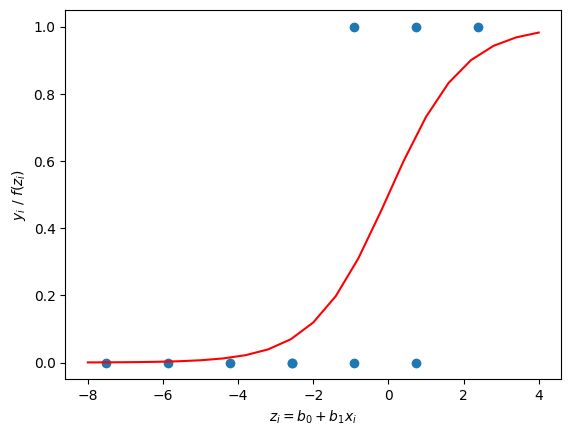

In [ ]:
Z = np.dot(Xlot,beta)
plt.scatter(Z,Ylot)
zlst = np.linspace(-8,4,21)
plt.plot(zlst,logifun(zlst),"r-")
plt.xlabel("$z_i = b_0 + b_1 x_i$")
plt.ylabel("$y_i$ / $f(z_i)$")

# ロジスティック回帰の実際

## **(例題)** 真札・偽札分類

ここまで、簡単な例題を使って説明してきましたが、もう少し実際的な例題を扱ってみたいと思います。例によって、UCI Machine Learning Repository から手頃と思われるデータ・タスク[”Banknote Authentication”](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)を探してきました。
データセットの説明によると、紙幣の画像から計測・抽出した4個の特徴量（説明変数）($x_1,x_2,x_3,x_4$)を用いて、その紙幣が本物($y=0$)か偽物($y=1$)かを判別するのが目的です。

今回も、データファイル("data_banknote_authentication.txt")を、Googleドライブのマイドライブ直下に置くことを前提として話を進めます。
事前にファイルをテキストエディタ等で開いて中を見てみるとわかるのですが、
* ファイルの拡張子は".txt"となっていますが、実際にはカンマ区切りのフォーマット(CSV)です。
* このファイルには<font color="red">ヘッダー行がありません</font>。Pandasの`read_csv()`関数で読み込むときに、`header=None`というオプションをつけます。また、必須ではありませんが、`names=`オプションを使って各列の名前を自分でつけることもできます。

In [ ]:
dfbn = pd.read_csv('/content/drive/My Drive/data_banknote_authentication.txt',header=None,names=["x1","x2","x3","x4","y"])
dfbn

,x1,x2,x3,x4,y
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


ファイルの前半に真札($y=0$)のデータ、後半に偽札($y=1$)のデータが集められているようです。

変数間の相関、データの概要を見てみると、

In [ ]:
# 相関行列
print("Correlation matrix:")
display(dfbn.corr())
# データの要約
print("Data summary:")
display(dfbn.describe())
# 真札・偽札の数
print("Number of authentic notes:",(dfbn["y"]==0).sum())
print("Number of forged notes:",(dfbn["y"]==1).sum())


Correlation matrix:


,x1,x2,x3,x4,y
x1,1.000000,0.264026,-0.380850,0.276817,-0.724843
x2,0.264026,1.000000,-0.786895,-0.526321,-0.444688
x3,-0.380850,-0.786895,1.000000,0.318841,0.155883
x4,0.276817,-0.526321,0.318841,1.000000,-0.023424
y,-0.724843,-0.444688,0.155883,-0.023424,1.000000


Data summary:


,x1,x2,x3,x4,y
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


Number of authentic notes: 762
Number of forged notes: 610


4つの説明変数のばらつきはそれほど大きくは無いですが、後で係数を比較するときの解釈性を考慮して、全データについて各説明変数が平均0,標準偏差1となるように標準化することにします。

また、データの順番をランダムにシャッフルした上で、訓練データとテストデータに半分ずつ分割します。この処理は、randomモジュールやnumpy.randomサブモジュールの`shuffle()`関数などを使って自分で実装しても大した手間ではありませんが、ここでは、Scikit-learnに含まれる `train_test_split()`関数を使って楽をすることにします。

以下のコードで、
* 訓練データ (説明変数: Xtr, 目標変数: ytr)
* テストデータ (説明変数: Xte, 目標変数: yte)
を準備しています。

<font color="red"> この時点では、説明変数データの行列`Xtr`,`Xte`</font>には`1`の列がありません。

In [ ]:
from sklearn.model_selection import train_test_split
dfbnx = dfbn.iloc[:,:4] # 4つの説明変数を取り出す
dfbnx = (dfbnx-dfbnx.mean())/dfbnx.std() # 説明変数を標準化
Xtr,Xte,ytr,yte = train_test_split(dfbnx.values,dfbn.iloc[:,4].values,test_size=0.5,random_state=1234)

## Scikit-learn のロジスティック回帰モデルの利用

本例題(の訓練データ)に対して、前述した<font color="red">ニュートン法に基づくアルゴリズムで自分でロジスティック回帰モデルのパラメータを求めるのは本日の課題でやってもらう</font>として、ここでは、scikit-learn のLogisticRegressionを使ってやってみます。

### LogisticRegressionモデルの訓練

前述のように、<font color="red">scikit-learnのロジスティック回帰では、デフォルト(既定)でL2正則化が有効になっていますが、`penalty=None`オプションでこれを解除</font>しています。

In [ ]:
# L2正則化はオフ
mdl_lr = LogisticRegression(penalty=None)
# 訓練データでモデルを学習
mdl_lr.fit(Xtr,ytr)
# パラメータの切片(b0)
print(mdl_lr.intercept_)
# 残りのパラメータ(b1,..,b4 )
print(mdl_lr.coef_)

[-19.23747012]
[[-39.58183971 -44.90907261 -41.55315514  -2.57686289]]


### 訓練したロジスティック回帰モデルによる分類（結果の予測）

訓練を行ったロジスティック回帰モデルのパラメータ$\hat{\boldsymbol{\beta}}$を使って、与えられた説明変数ベクトル$\boldsymbol{x}$を分類すること、すなわち、
目標変数$y$の値(0または1)を予測するには、ロジスティック関数に$\hat{\boldsymbol{\beta}} \cdot \boldsymbol{x}$を入れた値、すなわち、
$$
f(\hat{\boldsymbol{\beta}}\cdot \boldsymbol{x})=\frac{1}{1+e^{-\hat{\boldsymbol{\beta}}\cdot \boldsymbol{x}}}
$$
が中間の確率0.5よりも大きいか小さいかを見れば良いので、
$$
\hat{y} = \left\{
  \begin{matrix}
  0 & \mbox{if $\frac{1}{1+e^{-\hat{\boldsymbol{\beta}}\cdot \boldsymbol{x}}} < 0.5$} \\
  1 & \mbox{if $\frac{1}{1+e^{-\hat{\boldsymbol{\beta}}\cdot \boldsymbol{x}}} \geq 0.5$}
  \end{matrix}
  \right.
$$
とすれば良いのですが、そもそもロジスティック関数が単調増加であること、また、$f(0)=0.5$であることを考えれば、もっと簡単に、$\hat{\boldsymbol{\beta}} \cdot \boldsymbol{x}$ の符号を見れば良いことが分かります。すなわち、
$$
\hat{y} =  
\left\{
  \begin{matrix}
  0 & \mbox{if $\hat{\boldsymbol{\beta}}\cdot \boldsymbol{x} < 0$} \\
  1 & \mbox{if $\hat{\boldsymbol{\beta}}\cdot \boldsymbol{x} \geq 0$}
  \end{matrix}
  \right.
$$
です。

ただし、Scikit-learn の LogsiticRegressionクラスでは、`predict()`メソッドが用意されていて、テストデータ（および訓練データ）の説明変数のデータを与えるだけで、分類結果を0または1の値で返してくれます。


In [ ]:
# 訓練データについて予測し直したラベル
yhtr = mdl_lr.predict(Xtr)
print("Prediction on training data:\n",yhtr)
# テストデータについての予測ラベル
yhte = mdl_lr.predict(Xte)
print("Prediction on test data:\n",yhte)


Prediction on training data:
 [0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1
 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0
 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0
 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0
 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0
 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1
 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1

In [ ]:
# predict()メソッドを使わない場合
# z = b_0 + b_1 x_1 + ... + b_4 x_4 を計算
zte = mdl_lr.intercept_[0] + np.dot(Xte,mdl_lr.coef_.reshape(-1))
# 0 より大きいか、小さいかを判定して、True, False を 1, 0 に変換
yte = (zte >= 0).astype("int")
print(yte)

[0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0
 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0
 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0
 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1
 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0
 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0
 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1
 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1
 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1
 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0
 1 1 1 0 0 0 1 0 1 0 1 1 

### 分類結果の評価

回帰の場合は目標変数は連続値（実数値）を取るので、モデルの評価は、真値$y_i$とモデルによる予測値$\hat{y}_i$との差 $y_i - \hat{y}_i$に基づいて、平方根平均二乗誤差(RMSE)などを用いるのが一般的です。

それに対して、分類の場合は目標変数が離散値（カテゴリー値）を取るので、<font color="red">真値と予測値との差 $y_i - \hat{y}_i$ 自体はあまり意味を持たず</font>、<font color="blue">$y_i$と$\hat{y}_i$との値の組み合わせに意味があります</font>。

具体的に、今回扱っているような二値分類の場合、次のような混同行列(confusion matrix)と呼ばれる$2 \times 2$の表で、$y_i$と$\hat{y}_i$の組み合わせパターンを表すことができます。

|     | $\hat{y}=0$ | $\hat{y}=1$ |
|-----|-------------|--------------|
|$y=0$|True Negative (TN)|False Positive (FP)|
|$y=1$|False Negative (FN)|True Positive (TP)|

真値と予測値とが一致しているか、一致していないかだけを評価すれば良さそうなものですが、現実の分類問題（例えば病気の診断など）では、<font color="red">「陽性と予測して実際は陰性だった場合」（偽陽性）と、「陰性と予測して実際は陽性だった場合」（偽陰性）とは明確に区別する必要</font>があります。


とりあえず、今回の例題の訓練データおよびテストデータについて、混同行列を求めてみましょう。Scikit-learn には、`sklearn.metrics.confusion_matrix()`という関数が用意されていて、目標変数の真値$y$のリストと、予測値$\hat{y}$のリストを与えれば、すぐに計算してくれます。

In [ ]:
from sklearn.metrics import confusion_matrix

# 訓練データの混同行列
cmtr = confusion_matrix(ytr,yhtr)
print(cmtr)

# テストデータの混同行列
cmte = confusion_matrix(yte,yhte)
print(cmte)

[[378   2]
 [  1 305]]
[[378   0]
 [  0 308]]


ちなみに、今回のように、$y$が0か1かを取る場合であれば、ベクトル・行列演算を使って次のように自分で混同行列を計算するのも簡単です。

In [ ]:
np.dot(np.stack((1-ytr,ytr)),np.stack((1-yhtr,yhtr)).T)

array([[378,   2],
       [  1, 305]])

この混同行列を使って、いくつかの性能指標が定義されているのですが、今回は(時間も無いので、、)シンプルに、正答率(accuracy)だけ見ることにします。
$$
Accuracy = \frac{予測値と真値が一致した数}{全サンプル数} = \frac{TP+TN}{TP+TN+FP+FN}
$$

In [ ]:
# 訓練データの正答率
acc_tr = (cmtr[0,0]+cmtr[1,1])/np.sum(cmtr)
print("Training accuracy=",acc_tr)
# テストデータの正答率
acc_te = np.sum(np.diag(cmte))/np.sum(cmte)
print("Test accuracy=",acc_te)


Training accuracy= 0.9956268221574344
[378 308]
Test accuracy= 1.0


今回は、たまたま、テストデータの正答率が1.0、すなわち100%になりましたが、回帰のときと同様、分類においても、（期待値を取れば）訓練時の正答率よりもテスト時の正答率は悪化します。


### ロジスティック関数との当てはまり具合

冒頭でも話したように、ロジスティック回帰は分類の方法なのに「回帰」というワードが含まれています。

最後に、その理由を確認する目的も兼ねて、
$$
z_i = b_0 + b_1 \cdot x_1 + \cdots + b_4 \cdot x_4 = \boldsymbol{\beta}\cdot \boldsymbol{x}_i
$$
と$y_i$の値を散布図でプロットし、そこに、標準ロジスティック関数
$$
y = \frac{1}{1+e^{-z}}
$$
を重ねてプロットしてみます。

Text(0, 0.5, 'y')

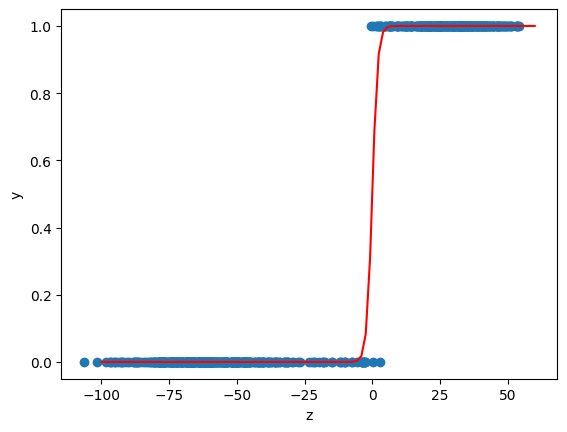

In [ ]:
# 訓練データ
ztr = np.dot(Xtr,mdl_lr.coef_.reshape(-1))+mdl_lr.intercept_
plt.scatter(ztr,ytr)
zarr = np.linspace(-100,60,101)
plt.plot(zarr,logifun(zarr),"r-")
plt.xlabel("z")
plt.ylabel("y")

Text(0, 0.5, 'y')

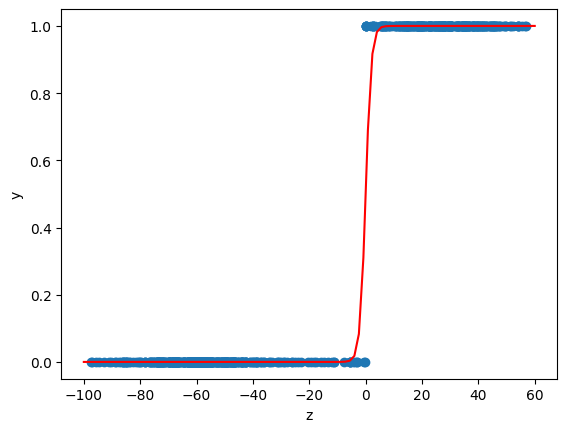

In [ ]:
# テストデータ
zte = np.dot(Xte,mdl_lr.coef_.reshape(-1))+mdl_lr.intercept_
plt.scatter(zte,yte)
plt.plot(zarr,logifun(zarr),"r-")
plt.xlabel("z")
plt.ylabel("y")

これらのグラフから明らかなように、ロジスティック回帰は、説明変数$\boldsymbol{x}$を中間変数$z$に線形変換させた後、$z$を0か1の値を取る目標変数$y$にフィットさせています。言い換えれば、目標$y$を$z$を経由して確かに$\boldsymbol{x}$に回帰させています。

# 今日の課題

最後に扱った「紙幣の真偽のデータセット」を使ってロジスティック回帰をもう少し深く追求してみます。詳細は別ファイルを参照してください。